In [10]:
import numpy as np
import torch
torch.set_default_tensor_type(torch.DoubleTensor)

import matplotlib.pyplot as plt

rng = np.random.default_rng()

T = 200 # how long to simulate the trajectory
state_dim = 2 # Dimension of the state-space
input_dim = 1 # Dimension of inputs
obs_dim = state_dim # for now
NUM_TRAJ_TRAIN = 100 # number of trajectories to simulate for training data
NUM_TRAJ_TEST = 20
num_trajs = NUM_TRAJ_TRAIN + NUM_TRAJ_TEST

import time

In [11]:
theta = 1/360*2*np.pi # one degree

A = np.array([[np.cos(theta), -np.sin(theta)], # state transition matrix
              [np.sin(theta),  np.cos(theta)]]) # moving around a circle at 1 deg per timestep
B = np.array([[0.5], [0.7]]) # input transformation
# B = np.zeros(shape=(state_dim, input_dim)) # ignore inputs for now
C = np.eye(obs_dim, state_dim) # Using identity map for now
Q = 0.001*np.eye(state_dim) # Covariance matrix of process noise
R = 0.01*np.eye(obs_dim) # Covariance matrix of sensor noise
x0 = np.array([1.0, 0.0], dtype=np.float64) # starting state
u_seq = 0.05 * (rng.random(size=(num_trajs, T, input_dim))*2 - 1)
traj = np.zeros(shape=(num_trajs, T, state_dim))
meas = np.zeros(shape=(num_trajs, T, obs_dim))

for traj_index in range(num_trajs):
    x = x0
    for i in range(T):
        u_t = u_seq[traj_index, i]
        w_t = rng.multivariate_normal(mean=np.zeros(state_dim), cov=Q) # process noise
        x = A @ x + w_t + B @ u_t # inputs
        v_t = rng.multivariate_normal(mean=np.zeros(obs_dim), cov=R) # sensor noise
        y = C @ x + v_t
        traj[traj_index, i] = x
        meas[traj_index, i] = y

<Figure size 432x288 with 0 Axes>

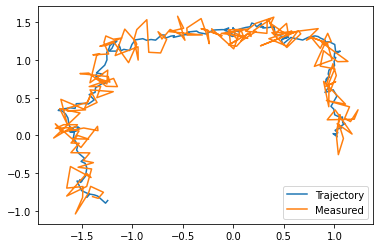

In [18]:
index_to_visualize = 40


# plot and create animations of trajectory and noisy measurements
plt.figure()
fig, ax = plt.subplots()
linetraj, = ax.plot(traj[index_to_visualize, :,0], traj[index_to_visualize, :,1], label='Trajectory')
linemeas, = ax.plot(meas[index_to_visualize, :,0], meas[index_to_visualize, :,1], label='Measured')

plt.legend()
plt.show()

# Now, let's see if a transformer can learn the dynamics and filter the position

In [19]:
from transformer import *
from transformer_attention import AttentionQKV
from transformer_attention import MultiHeadProjection
from transformer import PositionEmbedding

## GPT-style: Transformer Decoder only for Autoregressive generation

Compare to:
* Just the last timestep (ZOH) 
* Run A, B system on last timesteps (no noise) 

In [20]:
num_epochs = 20

embed_dim = 36 # use 36-dimensional embedding for now
output_size = state_dim # trying to recover 2-dim hidden state

batch_size = 10
sequence_len = T

model = TransformerDecoder(obs_dim + input_dim, embed_dim, output_size,
                 n_layers=3, n_heads=6, d_filter=256, dropout=None)
optimizer = torch.optim.Adam(model.parameters())

indices_train = np.arange(NUM_TRAJ_TRAIN)
np.random.shuffle(indices_train)
target_sequences_train = torch.from_numpy(meas)[indices_train,:,:]
input_sequences_train = torch.from_numpy(u_seq)[indices_train,:,:]
transformer_input = torch.cat((target_sequences_train, input_sequences_train), dim=2)

losses = []

for i in range(num_epochs):
    
    for batchNum in range(NUM_TRAJ_TRAIN // batch_size):
        
        transformer_input_batch = transformer_input[batchNum*batch_size:(batchNum+1)*batch_size, :, :]
        target_sequence_batch = target_sequences_train[batchNum*batch_size:(batchNum+1)*batch_size, :, :]
        
        decoder_output = model(transformer_input_batch, decoder_mask=None, mask_future=True, shift_target_sequence_right=False)

        loss_func = torch.nn.MSELoss(reduction='sum')
        loss = loss_func(decoder_output, target_sequence_batch)#[:, 1:, :])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        curr_loss = loss.item()
        losses.append(curr_loss)
        
    print('Epoch', i, ": Loss", curr_loss)

Epoch 0 : Loss 317.7114665013194
Epoch 1 : Loss 112.4774137491596
Epoch 2 : Loss 26.576066776340028
Epoch 3 : Loss 8.74571205117701
Epoch 4 : Loss 3.4632215553990653
Epoch 5 : Loss 2.217647671712873
Epoch 6 : Loss 1.9635073071902125
Epoch 7 : Loss 1.7490766633460493
Epoch 8 : Loss 1.5382381531969953
Epoch 9 : Loss 1.1077214838184375
Epoch 10 : Loss 0.8572856922667662
Epoch 11 : Loss 0.7827347189690272
Epoch 12 : Loss 0.6661430711695365
Epoch 13 : Loss 0.5638054395212323
Epoch 14 : Loss 0.4962952479422516
Epoch 15 : Loss 0.4519597816093487
Epoch 16 : Loss 0.4218733613044634
Epoch 17 : Loss 0.402761123277043
Epoch 18 : Loss 0.38603545763073516
Epoch 19 : Loss 0.36557358865406686


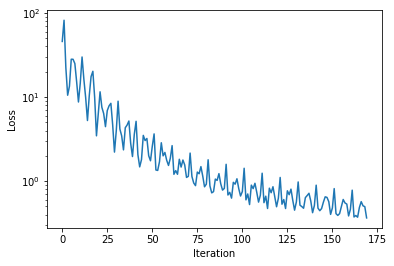

In [21]:
plt.figure()
plt.plot(losses[30:])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.yscale("log")
plt.show()

<Figure size 432x288 with 0 Axes>

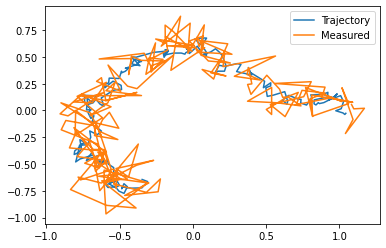

<Figure size 432x288 with 0 Axes>

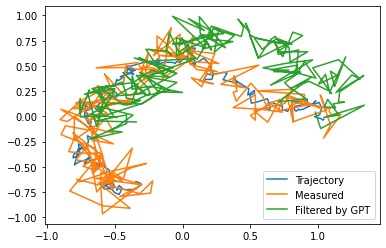

In [23]:
# Test the model

indices_test = np.arange(NUM_TRAJ_TRAIN, NUM_TRAJ_TRAIN+NUM_TRAJ_TEST)
np.random.shuffle(indices_test)
target_sequences_test = torch.from_numpy(meas)[indices_test,:,:]
input_sequences_test = torch.from_numpy(u_seq)[indices_test,:,:]
transformer_input_test = torch.cat((target_sequences_test, input_sequences_test), dim=2)

gpt_transformer_sim =  model(transformer_input_test, decoder_mask=None, mask_future=True, shift_target_sequence_right=False)

xs_pred = gpt_transformer_sim[0, :, 0].detach().numpy() 
ys_pred = gpt_transformer_sim[0, :, 1].detach().numpy()

plt.figure()
fig, ax = plt.subplots()
linetraj, = ax.plot(traj[0, :,0], traj[0, :,1], label='Trajectory')
linemeas, = ax.plot(meas[0, :,0], meas[0, :,1], label='Measured')
plt.legend()
plt.show()


plt.figure()
fig, ax = plt.subplots()
linetraj, = ax.plot(traj[0, :,0], traj[0, :,1], label='Trajectory')
linemeas, = ax.plot(meas[0, :,0], meas[0, :,1], label='Measured')
linegpt, = ax.plot(xs_pred, ys_pred, label='Filtered by GPT')
plt.legend()
plt.show()

## BERT-style: Transformer Encoder only, fill in the blanks for the trajectory 

Compare to: 
* Average between different timesteps for the missing ones (PWL linear interpolation)
* Just the last step (ZOH interpolation)

In [ ]:
model = TransformerEncoder()